In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Read data

In [145]:
# Read data
uncertainty = pd.read_csv('../data/processed/uncertainty_index.csv')

# Semiconductor ETF price
etf_price = pd.read_csv('../data/processed/etf_price.csv')

In [150]:
# Merge
data = pd.merge(uncertainty,etf_price,on='Period')

# Convert 'Period' to datetime
data['Period'] = pd.to_datetime(data['Period'])

# Create a new column 'etf_diff' representing the difference (lagged by 1 period) 
data['etf_diff'] = data['etf_price'].diff()
data.dropna(inplace=True)

# Keep columns
data = data[['Period', 'uncertainty' , 'etf_diff']]


In [151]:
data

,Period,uncertainty,etf_diff
1,2010-02-01,0.153836,0.975651
2,2010-03-01,0.254106,0.856191
3,2010-04-01,0.169631,0.284447
4,2010-05-01,0.358944,-0.938676
5,2010-06-01,0.116282,-0.969965
...,...,...,...
156,2023-01-01,3.734089,18.670380
157,2023-02-01,1.108370,2.026199
158,2023-03-01,1.139219,11.478394
159,2023-04-01,1.162030,-10.375199


### STNSU & ETF

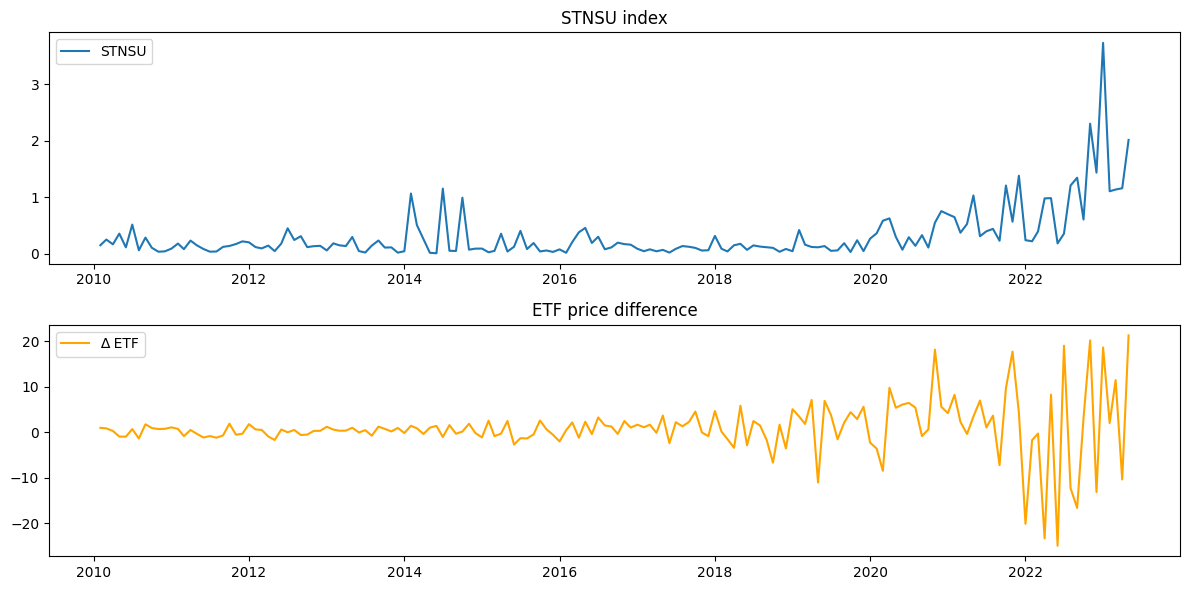

In [152]:
import matplotlib.pyplot as plt

# Set 'period' as the index
data.set_index('Period', inplace=True)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data['uncertainty'], label='STNSU')
plt.title('STNSU index')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['etf_diff'], label='∆ ETF', color='orange')
plt.title('ETF price difference')
plt.legend()

plt.tight_layout()
plt.show()


### Model


In [153]:
data

,uncertainty,etf_diff
Period,,
2010-02-01,0.153836,0.975651
2010-03-01,0.254106,0.856191
2010-04-01,0.169631,0.284447
2010-05-01,0.358944,-0.938676
2010-06-01,0.116282,-0.969965
...,...,...
2023-01-01,3.734089,18.670380
2023-02-01,1.108370,2.026199
2023-03-01,1.139219,11.478394


Stationarity

In [156]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity: Augmented Dickey-Fuller (ADF) Test
# Null Hypothesis: The time series has a unit root (is non-stationary).
def test_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

print("Testing etf_diff:")
test_stationarity(data['etf_diff']) # reject the null hypothesis and conclude that the series is stationary.

print("\nTesting uncertainty:")
test_stationarity(data['uncertainty']) # non-stationary

Testing etf_diff:
ADF Statistic: -3.5259403068312207
p-value: 0.007345354941696817

Testing uncertainty:
ADF Statistic: 2.854449981893027
p-value: 1.0


Cointegration
Engle-Granger approach

In [157]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Perform OLS regression: Regress X (non-stationary) on Y (stationary)
X = sm.add_constant(data['uncertainty'])  # Add a constant term for the intercept
model = sm.OLS(data['etf_diff'], X)
result = model.fit()

# Get residuals from the regression
residuals = result.resid

# Perform ADF test on residuals to check for stationarity
adf_test = adfuller(residuals)

# Print results
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

# Interpretation
if adf_test[1] < 0.05:
    print("The residuals are stationary, suggesting cointegration between X and Y.")
else:
    print("The residuals are non-stationary, suggesting no cointegration between X and Y.")


ADF Statistic: -3.656905604472182
p-value: 0.00476180746088372
Critical Values: {'1%': -3.4759527332353084, '5%': -2.881548071241103, '10%': -2.577438765246763}
The residuals are stationary, suggesting cointegration between X and Y.


ADL model
https://www.econometrics-with-r.org/14.5-apatadlm.html
optional: add shade for specific period

In [ ]:
# Set target and feature data
Y = data['etf_diff']
X = data['uncertainty']

In [205]:
from statsmodels.tsa.ardl import ardl_select_order

# Selecting the optimal lag order for ARDL
selected_model = ardl_select_order(endog=data['etf_diff'], maxlag=10, exog=data[['uncertainty']], maxorder=10, ic='bic')

# Fit the ARDL model with selected lags
ardl_model = selected_model.model.fit()
print(ardl_model.summary())


                              ARDL Model Results                              
Dep. Variable:               etf_diff   No. Observations:                  160
Model:                     ARDL(1, 0)   Log Likelihood                -502.645
Method:               Conditional MLE   S.D. of innovations              5.711
Date:                Sat, 10 Aug 2024   AIC                           1013.290
Time:                        21:45:42   BIC                           1025.566
Sample:                    03-01-2010   HQIC                          1018.275
                         - 05-01-2023                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0665      0.561      0.119      0.906      -1.041       1.174
etf_diff.L1       -0.2604      0.078     -3.356      0.001      -0.414      -0.107
uncertainty.L0     3.2295      0.980

/Users/ouharuhua/anaconda3/envs/Code_for_thesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ouharuhua/anaconda3/envs/Code_for_thesis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [201]:
# Convert ARDL to ECM
ecm_resid = ardl_model.resid

# Create the ECM term by differencing the non-stationary series and adding the lagged residual
data['ecm_resid'] = ecm_resid.shift(1)
data['d_uncertainty'] = data['uncertainty'].diff()
# Difference the dependent variable (ETF stock price difference)
data['d_etf_diff'] = data['etf_diff'].diff()

# Drop NaN values that result from differencing and shifting
data_ecm = data[['d_etf_diff', 'd_uncertainty', 'ecm_resid']].dropna()

# Fit the ECM
ecm_fit = sm.OLS(data_ecm['d_etf_diff'], sm.add_constant(data_ecm[['d_uncertainty', 'ecm_resid']])).fit()
print(ecm_fit.summary())


                            OLS Regression Results                            
Dep. Variable:             d_etf_diff   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     113.1
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           5.25e-31
Time:                        20:44:32   Log-Likelihood:                -509.93
No. Observations:                 158   AIC:                             1026.
Df Residuals:                     155   BIC:                             1035.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0230      0.490     -0.047

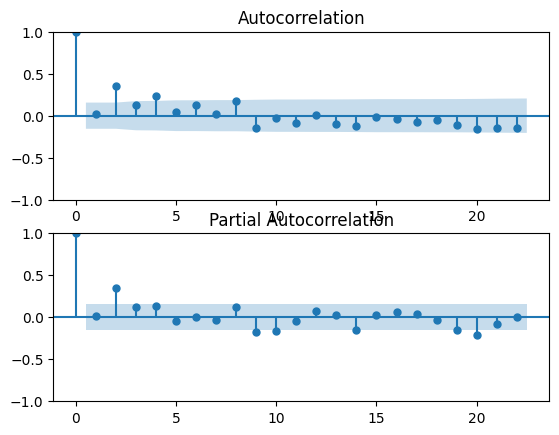

(1.3705554861819491, 0.04671405276396076, [(1, 1.63), (5, 1.36), (10, 1.22)])

In [202]:
# Residual diagnostics
fig, ax = plt.subplots(2, 1)
sm.graphics.tsa.plot_acf(ecm_fit.resid, ax=ax[0])
sm.graphics.tsa.plot_pacf(ecm_fit.resid, ax=ax[1])
plt.show()

# Stability tests (CUSUM)
sm.stats.diagnostic.breaks_cusumolsresid(ecm_fit.resid)
